In [1]:
import yt 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import functions

In [2]:
data = r"../data" # Location of saved simulations
sim = r'cooling_1_1e7' # simulation to look at
snapshot = r'plt307200' # snapshot within simulation
fields = ['RHOB', 'WVX', 'WVY', 'WVZ', 'EPS'] # fields


In [ ]:
History = np.loadtxt(f'{data}/{sim}/output_history.asc', skiprows=1)
# sum, max, min
# 0, 1, 2 = RHOSTAR; 3, 4, 5 = TEMP; 6, 7, 9 = Lorentz; 9, 10, 11 = Kinetic; 12, 13, 14 = RHOSTAR_TEMP



rhostar_t = History[:, 13]
rhostar_t = [i for j, i in enumerate(rhostar_t, start=1) if (j % 81 != 0) or (j % 80 != 0)]
rhostar_t = np.array(rhostar_t)

rhostar = History[:, 1]
rhostar = [i for j, i in enumerate(rhostar, start=1) if (j % 81 != 0) or (j % 80 != 0)]
rhostar = np.array(rhostar)

average_t = rhostar_t/rhostar

hist_len = len(rhostar)
t_factor = 80.98333 # adjust the scale of the x axis to the total time length

t = np.linspace(0, hist_len/t_factor, hist_len)

plt.figure(figsize=(12, 8))

plt.plot(t, average_t)

plt.xlabel(r'Time $T$')
plt.ylabel(r'Average Temperature $T$')
plt.grid()

os.makedirs(f'../figures/{sim}', exist_ok=True)
plt.savefig(f'../figures/{sim}/temp_history.png', dpi=300)


In [ ]:
lorentz_max = History[:, 7]
lorentz_max = [i for j, i in enumerate(lorentz_max, start=1) if (j % 81 != 0) or (j % 80 != 0)]

hist_len = len(lorentz_max)

t = np.linspace(0, hist_len/t_factor, hist_len)

plt.figure(figsize=(12, 8))

plt.plot(t, lorentz_max)

plt.xlabel(r'Time $T$')
plt.ylabel(r'Max Lorentz Factor $\Gamma$')
plt.grid()

os.makedirs(f'../figures/{sim}', exist_ok=True)
plt.savefig(f'../figures/{sim}/lorentz_history.png', dpi=300)


In [3]:
ds, cube = functions.load_snapshot(f"{data}/{sim}/{snapshot}", fields)

rho = cube["RHOB"].d
eps = cube["EPS"].d
temp = eps/rho

lorentz = functions.lorentz(cube)

k, E_spectrum = functions.make_ke_ps(ds, cube)
index = np.argmax(E_spectrum)
kmax = k[index]
Emax = E_spectrum[index]

yt : [INFO     ] 2024-07-31 17:58:56,331 Parameters: current_time              = 300.0
yt : [INFO     ] 2024-07-31 17:58:56,332 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2024-07-31 17:58:56,332 Parameters: domain_left_edge          = [-1. -1.  0.]
yt : [INFO     ] 2024-07-31 17:58:56,333 Parameters: domain_right_edge         = [1. 1. 1.]


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14,12), dpi=300)

ax[0, 0].loglog(k, E_spectrum, label='Power Spectrum')
ax[0, 0].loglog(k, Emax*(k/kmax)**(-5/3), ls=':', color="0.5", label='Kolmogorov (1941) Power Law')
ax[0, 0].set_xlabel(r"$k$")
ax[0, 0].set_ylabel(r"$E(k)dk$")
ax[0, 0].set_ylim(1e-8, 1e-2)
ax[0, 0].grid()
ax[0, 0].legend()

im1 = ax[0, 1].pcolormesh(lorentz[:, :, 0], cmap='RdBu_r', vmin = 1, vmax=10)
ax[0, 1].set_xlabel(r'$x$', fontsize=15)
ax[0, 1].set_ylabel(r'$y$', fontsize=15)
fig.colorbar(im1, ax=ax[0,1], label=r'Lorentz Factor $\Gamma$')

im2 = ax[1, 0].pcolormesh(temp[:, :, 0], cmap="hot", vmin = 0, vmax = 5)
ax[1, 0].set_xlabel(r'$x$', fontsize=15)
ax[1, 0].set_ylabel(r'$y$', fontsize=15)
fig.colorbar(im2, ax=ax[1,0], label=r'Temperature $T$')

im3 = ax[1, 1].pcolormesh(rho[:, :, 0], cmap='plasma', norm=colors.LogNorm(vmin = 1e-5, vmax = 1e-1))
ax[1, 1].set_xlabel(r'$x$', fontsize=15)
ax[1, 1].set_ylabel(r'$y$', fontsize=15)
fig.colorbar(im3, ax=ax[1,1], label=r'Density $\rho_b$')

#plt.show()
os.makedirs(f'../figures/{sim}', exist_ok=True)
plt.savefig(f'../figures/{sim}/{snapshot}.png', dpi=300)

In [37]:

nx, ny, nz = ds.domain_dimensions
vx, vy, vz = functions.velocities(cube) 

vec_field = np.zeros( (nx, ny, nz, 3) )

for i in range(nx): 
    for j in range(ny): 
        for k in range(nz): 
            vec_field[i, j, k, 0] = vx[i, j, k]
            vec_field[i, j, k, 1] = vy[i, j, k]
            vec_field[i, j, k, 2] = vz[i, j, k]



In [60]:
p = 2
nx = 64 
ny = 64 
nz = 1

# create list of grid points to iterate through
ranges = [np.arange(0, dim) for dim in [nx, ny, nz]]
grid_points = np.array(np.meshgrid(*ranges)).T.reshape(-1, 3)

# some values to keep track of
steps = 4096

# total number of iterations to go through
iterations = int(steps * (steps-1)/2)
distances = np.zeros(iterations)
vel_structure = np.zeros(iterations)

count = 0
for i in range(steps-1):  
    # take the first coordinate
    p1 = grid_points[i]
    for p2 in grid_points[i+1:]: 
        # for every other coordinate find distance 
        distances[count] = np.linalg.norm(p2 - p1)

        # calculate velocity structure between the points
        vel_structure[count] = ( np.linalg.norm(vec_field[*p1, :] - vec_field[*p2, :]) )**p

        count += 1

nbins = 50 

# create bins to calculate the averages
bins = np.linspace(np.min(distances), np.max(distances), nbins+1) 

ensamble_avg = np.zeros(nbins)

for i in range(nbins): 
    # create mask where distances fall below a specific bin
    # use mask on the vel_structure and average them
    ensamble_avg[i] = np.average(vel_structure[np.where(distances < bins[i+1])])

In [61]:
log_bin = np.log10(bins[:nbins]) 
log_avg = np.log10(ensamble_avg) 

m, c = np.polyfit(log_bin, log_avg, 1)
fit = m * log_bin + c


print(m)

0.6874863273372122


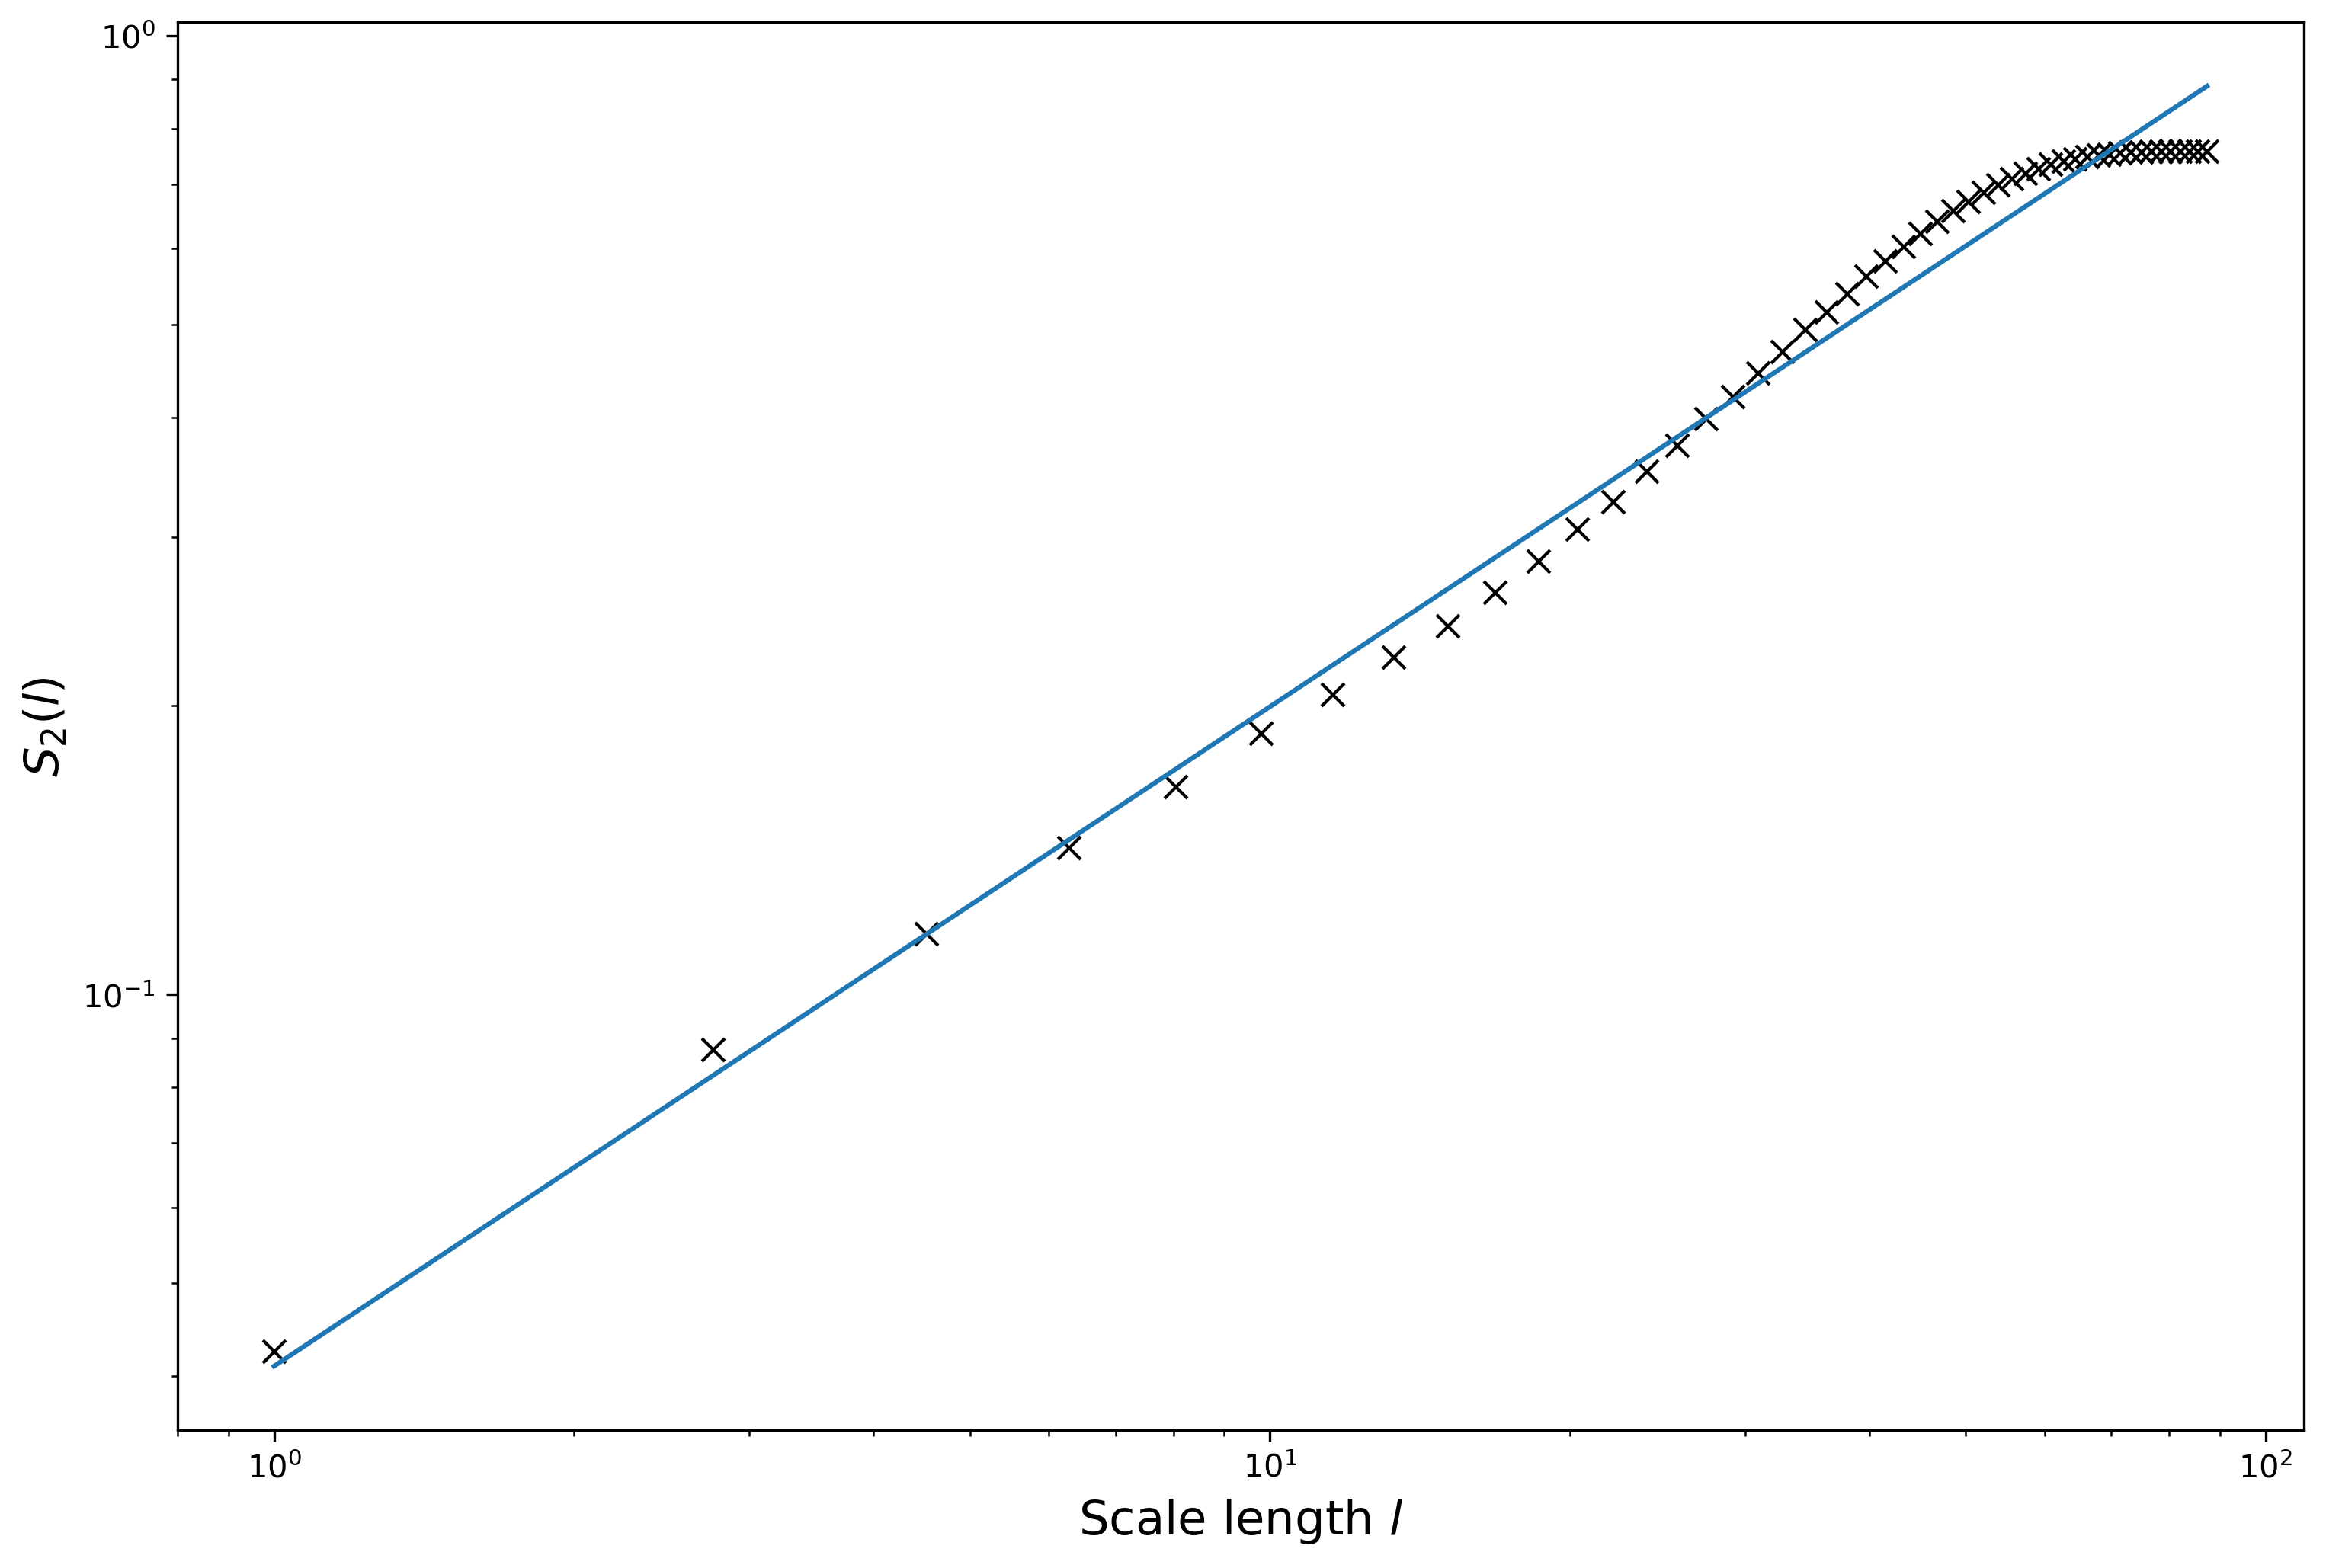

In [63]:
plt.figure(figsize=(12,8), dpi=300) 

plt.loglog(bins[:nbins], ensamble_avg, marker='x', ms=7, ls='', c='black') 
plt.loglog(bins[:nbins], 10**fit)

plt.xlabel(r'Scale length $l$', fontsize=15)
plt.ylabel(r'$S_2(l)$', fontsize=15)

os.makedirs(f'../figures/{sim}', exist_ok=True)
plt.savefig(f'../figures/{sim}/Velocity_structure.png', dpi=300)